In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.simplefilter('ignore')

In [2]:
#read csv
df = pd.read_csv('Small_DS_preprocessed.csv')

In [3]:
#remove the first column
df.head()

,runtime,imdb,votes,budgets,genre_encoded,companies_experience,directors_experience,stars_experience,writers_experience,day,month,year,weekDay,rating_encoded,origins_encoded
0,150,8.3,73855,250000000.0,2,29,4,11,6,5,5,2023,4,3,2
1,96,7.0,39889,12000000.0,164,29,1,1,1,21,4,2023,4,4,2
2,134,7.4,79732,150000000.0,2,73,2,5,2,31,3,2023,4,3,3
3,92,7.3,93663,100000000.0,46,88,1,11,2,5,4,2023,2,2,2
4,122,6.7,66427,35000000.0,167,73,3,6,7,10,3,2023,4,4,2


**Split data**

In [4]:
#Split data with holdout method
X = df.drop(['imdb'], axis=1)
y = df['imdb']
#Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Split test data into test and validation sets
X_hold, X_val, y_hold, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape, X_hold.shape, X_val.shape)
print(y_train.shape, y_hold.shape, y_val.shape)


(595, 14) (128, 14) (128, 14)
(595,) (128,) (128,)


# 2. Featrure Transformation

In [5]:
def draw_boxplots(df, columns):
    #draw boxplots vertically for each column in same figure horizontally
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    for i, col in enumerate(columns):
        sns.boxplot(x=col, data=df, ax=axes[i])
    plt.show()
def draw_hist(df, columns):
    #draw histograms vertically for each column in same figure horizontally
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    for i, col in enumerate(columns):
        sns.histplot(x=col, data=df, ax=axes[i], kde=True)
    plt.show()

In [6]:
def handle_outlier(X, Xtrain, type, feat):
    upper = 0
    lower = 0
    if type == 'skew':
        IQR=Xtrain[feat].quantile(0.75)-Xtrain[feat].quantile(0.25)
        lower=Xtrain[feat].quantile(0.25)-(IQR*3)
        upper=Xtrain[feat].quantile(0.75)+(IQR*3)
    else:
        upper=Xtrain[feat].mean() + 3* Xtrain[feat].std()
        lower=Xtrain[feat].mean() - 3* Xtrain[feat].std()
    X.loc[X[feat] >= upper, feat] = upper
    X.loc[X[feat] <= lower, feat] = lower
    return X

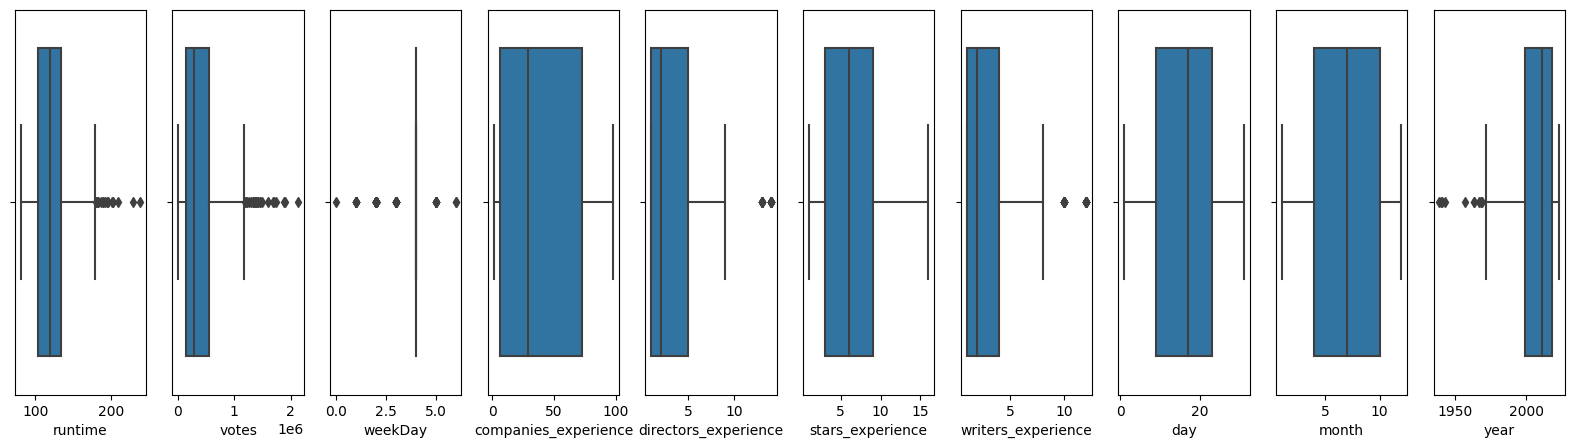

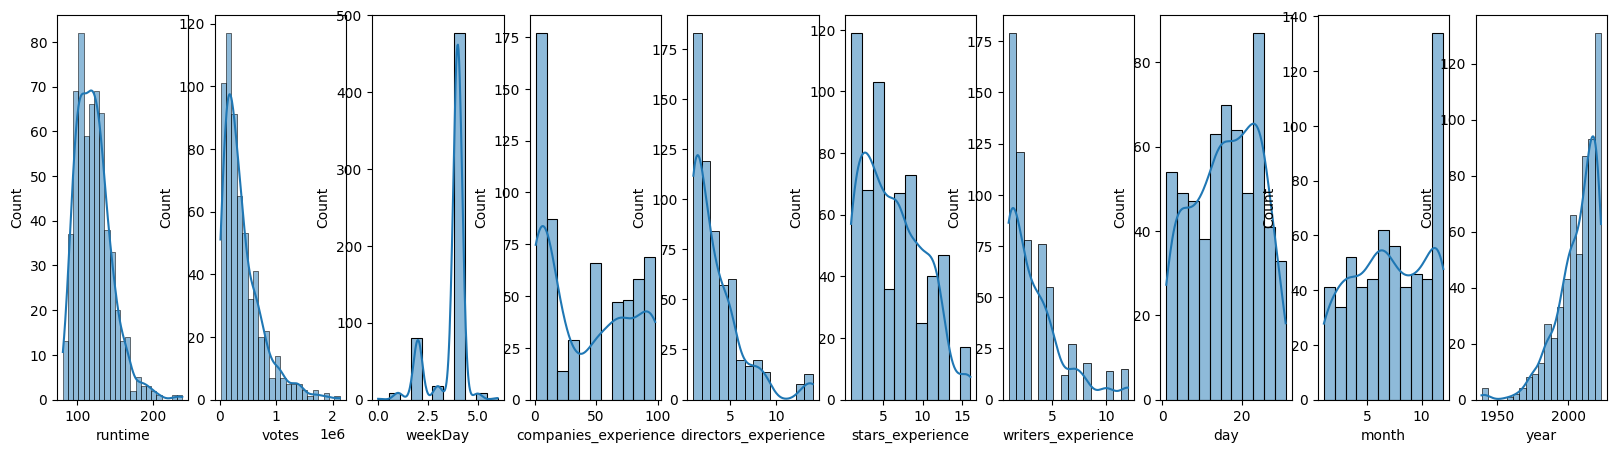

In [7]:
draw_boxplots(X_train, ['runtime','votes', 'weekDay', 'companies_experience','directors_experience','stars_experience','writers_experience','day','month', 'year'])
draw_hist(X_train, ['runtime', 'votes', 'weekDay', 'companies_experience','directors_experience','stars_experience','writers_experience','day','month', 'year'])

**1. Handle Outliers**

In [8]:
X_train = handle_outlier(X_train,X_train,"gauss","runtime")
X_train = handle_outlier(X_train,X_train,"skew","votes")

X_val = handle_outlier(X_val,X_train,"gauss","runtime")
X_val = handle_outlier(X_val,X_train,"skew","votes")

X_hold = handle_outlier(X_hold,X_train,"gauss","runtime")
X_hold = handle_outlier(X_hold,X_train,"skew","votes")

**2. Scaler**

In [9]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_hold = scaler.transform(X_hold)


# Model Training

In [10]:
def calc_score(y_val, y_pred, model_name):
    mae = mean_absolute_error(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    r2 = r2_score(y_val, y_pred)

    print(f'MAE - RMSE - R2 of {model_name}: ', round(mae,2), round(rmse,2), round(r2,2))
    return (mae, rmse, r2)

In [11]:
def scatter(y_pred_rf, y_pred_svm, y_val):
    plt.figure(figsize=(7, 7))
    plt.title('Biểu đồ phân tán giữa giá trị IMDB dự đoán và thực tế')
    plt.scatter(y_pred_rf, y_val, label='Random Forest Regressor', color='#ffa74a', alpha=0.5, s=100)
    plt.scatter(y_pred_svm, y_val, label='Support Vector Regressor', color='#9199c9', alpha=0.5, s=100)
    plt.axline((3, 3), slope=1, color='red', label='Perfect Fit')
    plt.xlabel('IMDB dự đoán')
    plt.ylabel('IMDB thực tế')
    plt.legend()
    plt.show()

In [12]:
rf_model = RandomForestRegressor()
svm_model = SVR(kernel="linear")

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_val)

# Đánh giá model
(mae_rf_1, rmse_rf_1, r2_rf_1) = calc_score(
    y_val, y_pred_rf, 'Random Forest')
(mae_svm_1, rmse_svm_1, r2_svm_1) = calc_score(y_val, y_pred_svm, 'SVM')


MAE - RMSE - R2 of Random Forest:  0.39 0.51 0.61
MAE - RMSE - R2 of SVM:  0.42 0.55 0.55


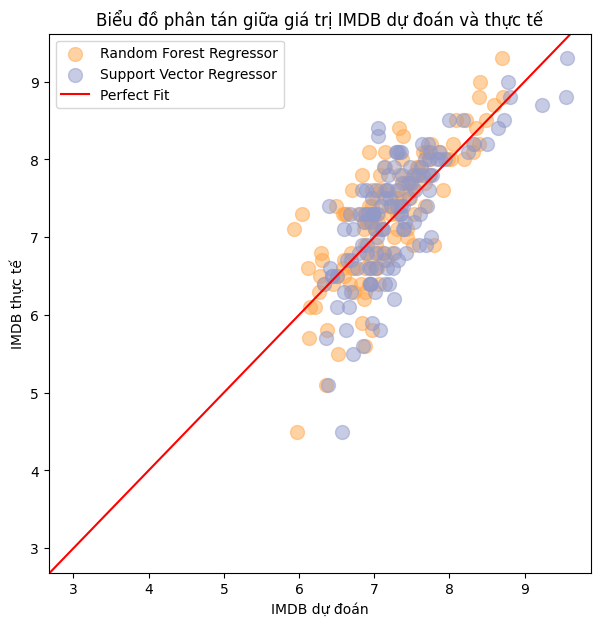

In [13]:
scatter(y_pred_rf, y_pred_svm, y_val)

Từ đồ thị phân tán giữa giá trị IMDB dự đoán và thực tế nhận thấy:
- Các bộ phim có IMDB thực tế thấp hơn 5 không được mô hình dự đoán tốt, sai số dự đoán lớn
-> Điều này có thể giải thích dữ liệu thu thập phân bố không đồng đều về điểm IMDB của phim, chỉ có <1% trên tổng số dữ liệu có điểm IMDB rơi vào khoảng 0-5

# Feature Selection
Lấy ra best feat mỗi lần lặp -> fit lại model -> tính lại score -> lặp lại 

In [14]:
selected_features_rf = []
print('Selected features with random forest estimator: ')
for i in range(10,14):
    selector_rf = RFE(estimator=rf_model, n_features_to_select=i, step=1).fit(X_train, y_train)

    print(df.drop('imdb', axis=1).columns[selector_rf.support_].tolist())
    selected_features_rf.append(df.drop('imdb', axis=1).columns[selector_rf.support_].tolist())

Selected features with random forest estimator: 
['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'stars_experience', 'writers_experience', 'day', 'month', 'year']
['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'directors_experience', 'stars_experience', 'writers_experience', 'day', 'month', 'year']
['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'directors_experience', 'stars_experience', 'writers_experience', 'day', 'month', 'year', 'rating_encoded']
['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'directors_experience', 'stars_experience', 'writers_experience', 'day', 'month', 'year', 'weekDay', 'rating_encoded']


In [15]:
selected_features_svm = []
print('Selected features with SVM estimator: ')
for i in range(10,14):
    selector_svm = RFE(estimator=svm_model, n_features_to_select=i, step=1).fit(X_train, y_train)

    print(df.drop('imdb', axis=1).columns[selector_svm.support_].tolist())
    selected_features_svm.append(df.drop('imdb', axis=1).columns[selector_svm.support_].tolist())


Selected features with SVM estimator: 
['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'directors_experience', 'writers_experience', 'year', 'rating_encoded', 'origins_encoded']
['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'directors_experience', 'writers_experience', 'month', 'year', 'rating_encoded', 'origins_encoded']
['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'directors_experience', 'stars_experience', 'writers_experience', 'month', 'year', 'rating_encoded', 'origins_encoded']
['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'directors_experience', 'stars_experience', 'writers_experience', 'month', 'year', 'weekDay', 'rating_encoded', 'origins_encoded']


In [16]:
best_features_rf = []
min_mae = 1
#cast to dataframe
X_train = pd.DataFrame(X_train, columns=df.drop('imdb', axis=1).columns)
X_val = pd.DataFrame(X_val, columns=df.drop('imdb', axis=1).columns)
for i in range(0,4):
    rf_model.fit(X_train[selected_features_rf[i]], y_train)
    svm_model.fit(X_train[selected_features_rf[i]], y_train)

    y_pred_rf = rf_model.predict(X_val[selected_features_rf[i]])
    y_pred_svm = svm_model.predict(X_val[selected_features_rf[i]])

    (mae_rf, rmse_rf, r2_rf) = calc_score(y_val, y_pred_rf, 'Random Forest')

    (mae_svm, rmse_svm, r2_svm) = calc_score(y_val, y_pred_svm, 'SVM')

    if mae_rf < min_mae:
        min_mae = mae_rf
        best_features_rf = selected_features_rf[i]

    if mae_svm < min_mae:
        min_mae = mae_svm
        best_features_rf = selected_features_rf[i]

MAE - RMSE - R2 of Random Forest:  0.39 0.51 0.61
MAE - RMSE - R2 of SVM:  0.41 0.54 0.56
MAE - RMSE - R2 of Random Forest:  0.39 0.51 0.6
MAE - RMSE - R2 of SVM:  0.41 0.54 0.56
MAE - RMSE - R2 of Random Forest:  0.38 0.5 0.62
MAE - RMSE - R2 of SVM:  0.41 0.54 0.56
MAE - RMSE - R2 of Random Forest:  0.38 0.5 0.62
MAE - RMSE - R2 of SVM:  0.41 0.54 0.56


In [17]:
best_features_svm = []
min_mae = 1
#cast to dataframe
X_train = pd.DataFrame(X_train, columns=df.drop('imdb', axis=1).columns)
X_val = pd.DataFrame(X_val, columns=df.drop('imdb', axis=1).columns)
for i in range(0,4):
    rf_model.fit(X_train[selected_features_svm[i]], y_train)
    svm_model.fit(X_train[selected_features_svm[i]], y_train)

    y_pred_rf = rf_model.predict(X_val[selected_features_svm[i]])
    y_pred_svm = svm_model.predict(X_val[selected_features_svm[i]])

    (mae_rf, rmse_rf, r2_rf) = calc_score(y_val, y_pred_rf, 'Random Forest')

    (mae_svm, rmse_svm, r2_svm) = calc_score(y_val, y_pred_svm, 'SVM')

    if mae_rf < min_mae:
        min_mae = mae_rf
        best_features_svm = selected_features_svm[i]

    if mae_svm < min_mae:
        min_mae = mae_svm
        best_features_svm = selected_features_svm[i]

MAE - RMSE - R2 of Random Forest:  0.38 0.5 0.63
MAE - RMSE - R2 of SVM:  0.42 0.55 0.55
MAE - RMSE - R2 of Random Forest:  0.39 0.5 0.62
MAE - RMSE - R2 of SVM:  0.42 0.55 0.55
MAE - RMSE - R2 of Random Forest:  0.38 0.51 0.62
MAE - RMSE - R2 of SVM:  0.42 0.55 0.55
MAE - RMSE - R2 of Random Forest:  0.38 0.5 0.63
MAE - RMSE - R2 of SVM:  0.42 0.55 0.55


In [18]:
print(len(best_features_svm), ' ', best_features_svm )
print(len(best_features_rf), ' ', best_features_rf)

10   ['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'directors_experience', 'writers_experience', 'year', 'rating_encoded', 'origins_encoded']
12   ['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'directors_experience', 'stars_experience', 'writers_experience', 'day', 'month', 'year', 'rating_encoded']


In [19]:
rf_model.fit(X_train[best_features_svm], y_train)
svm_model.fit(X_train[best_features_svm], y_train)

y_pred_rf_svmfeat = rf_model.predict(X_val[best_features_svm])
y_pred_svm_svmfeat = svm_model.predict(X_val[best_features_svm])

(mae_rf, rmse_rf, r2_rf) = calc_score(y_val, y_pred_rf_svmfeat, 'Random Forest')

(mae_svm, rmse_svm, r2_svm) = calc_score(y_val, y_pred_svm_svmfeat, 'SVM')

MAE - RMSE - R2 of Random Forest:  0.39 0.51 0.61
MAE - RMSE - R2 of SVM:  0.42 0.55 0.55


In [20]:
rf_model.fit(X_train[best_features_rf], y_train)
svm_model.fit(X_train[best_features_rf], y_train)

y_pred_rf_rffeat = rf_model.predict(X_val[best_features_rf])
y_pred_svm_rffeat = svm_model.predict(X_val[best_features_rf])

(mae_rf, rmse_rf, r2_rf) = calc_score(y_val, y_pred_rf_rffeat, 'Random Forest')

(mae_svm, rmse_svm, r2_svm) = calc_score(y_val, y_pred_svm_rffeat, 'SVM')

MAE - RMSE - R2 of Random Forest:  0.39 0.51 0.61
MAE - RMSE - R2 of SVM:  0.41 0.54 0.56


In [21]:
print('Feature selected:\n ', len(best_features_svm), best_features_svm)

(mae_rf_2, rmse_rf_2, r2_rf_2) = calc_score(y_val, y_pred_rf_svmfeat, 'Random Forest')
(mae_svm_2, rmse_svm_2, r2_svm_2) = calc_score(y_val, y_pred_svm_svmfeat, 'SVM')

Feature selected:
  10 ['runtime', 'votes', 'budgets', 'genre_encoded', 'companies_experience', 'directors_experience', 'writers_experience', 'year', 'rating_encoded', 'origins_encoded']
MAE - RMSE - R2 of Random Forest:  0.39 0.51 0.61
MAE - RMSE - R2 of SVM:  0.42 0.55 0.55


So sánh với kết quả các metrics trước khi lựa chọn đặc trưng:<br>
*MAE - RMSE - R2 of Random Forest:  0.39 0.51 0.61*<br>
*MAE - RMSE - R2 of SVM:  0.42 0.55 0.55*

-> Nhận thấy bước lựa chọn đặc trưng có cải thiện không đáng kể trên cả hai mô hình. Điều này có thể giải thích bởi độ tương quan giữa các đặc trưng với IMDB rating không cao (<0.5). Do đó,việc loại bỏ bớt các đặc trưng bằng thuậ toán RFE khó có thể cải thiện độ chính xác của mô hình, nhưng có thể tăng tốc độ tính toán của mô hình.<br>
-> Tiến hành lựa chọn tham số tối ưu cho mô hình để cải thiện độ chính xác

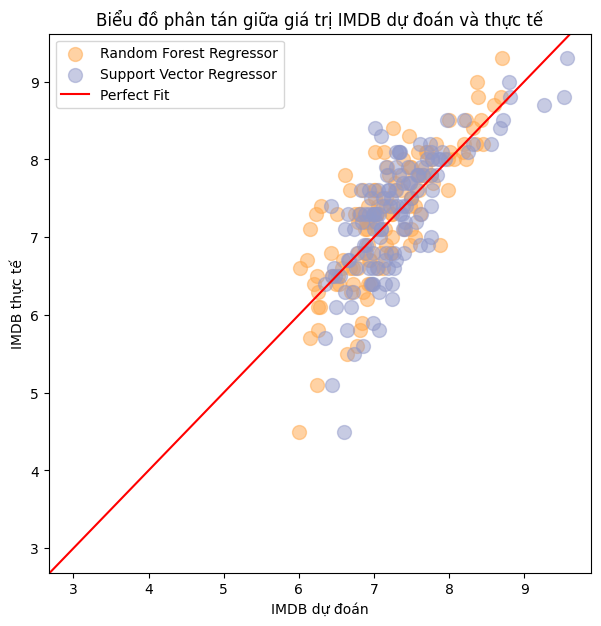

In [22]:
scatter(y_pred_rf_svmfeat, y_pred_svm_svmfeat, y_val)

**Optimize hyperparameters**

1. Random Forest Regressor

In [23]:
# Define the parameter grid
param_grid = {
    'n_estimators': [400, 500, 600, 700, 800, 900],  # Số lượng cây trong rừng
    'max_depth': [None, 5, 10],  # Độ sâu tối đa của cây
    'min_samples_split': [2, 5, 10],  # Số lượng mẫu tối thiểu để chia một nút trong cây
    'min_samples_leaf': [1, 2, 4],  # Số lượng mẫu tối thiểu trong mỗi lá của cây
    'max_features': ['auto', 'sqrt'],  # Số lượng đặc trưng được xem xét khi tìm kiếm phân chia tốt nhất
    'random_state': [42]  # Giá trị random_state để đảm bảo kết quả tái tạo được như nhau
}
# Create a grid search object
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
#cast X_val to dataframe with best features
X_val_tmp = pd.DataFrame(X_val, columns=df.drop('imdb', axis=1).columns)[best_features_svm]
X_train_tmp = pd.DataFrame(X_train, columns=df.drop('imdb', axis=1).columns)[best_features_svm]
# Fit the grid search object to the data
grid_search_rf.fit(X_train_tmp, y_train)
# Print the best parameters and score
print("Best parameters:", grid_search_rf.best_params_)
print("Best score:", grid_search_rf.best_score_)


Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 600, 'random_state': 42}
Best score: -0.40283911945853956


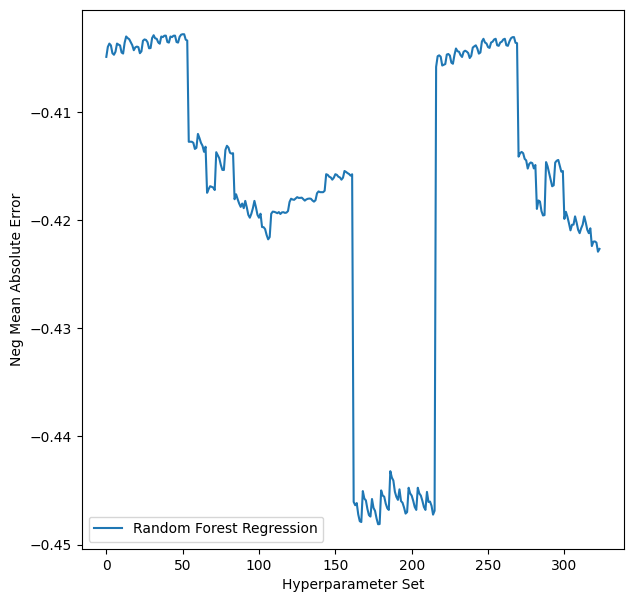

In [24]:
#plot loss function
plt.figure(figsize=(7, 7))
plt.plot(grid_search_rf.cv_results_['mean_test_score'], label='Random Forest Regression')
plt.xlabel('Hyperparameter Set')
plt.ylabel('Neg Mean Absolute Error')
plt.legend()

2. Support Vector Regressor

In [25]:
# define the range of hyperparameters
param_grid_svm = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1, 10]
}

# create a grid search object
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid_svm, cv=5, scoring='neg_mean_absolute_error')

X_val_tmp = pd.DataFrame(X_val, columns=df.drop('imdb', axis=1).columns)[best_features_svm]
X_train_tmp = pd.DataFrame(X_train, columns=df.drop('imdb', axis=1).columns)[best_features_svm]

# fit the grid search to the data
grid_search_svm.fit(X_train_tmp, y_train)

# print the best hyperparameters and the corresponding mean squared error
print(grid_search_svm.best_params_)
print(-grid_search_svm.best_score_)


{'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}
0.40643940276462853


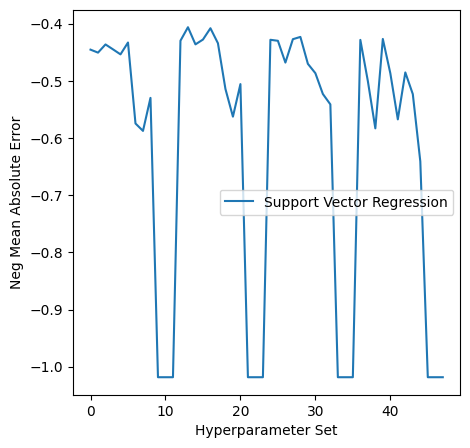

In [26]:
#plot loss function
plt.figure(figsize=(5, 5))
filtered_neg_mae = [score for score in grid_search_svm.cv_results_['mean_test_score'] if score > -1]
plt.plot(grid_search_svm.cv_results_['mean_test_score'], label='Support Vector Regression')
plt.xlabel('Hyperparameter Set')
plt.ylabel('Neg Mean Absolute Error')
plt.legend()

Retrain model with best hyperparameters

In [27]:
# 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 600, 'random_state': 42
# 'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'
rf_model = RandomForestRegressor(max_depth = None, max_features = 'auto', min_samples_leaf = 4, min_samples_split = 10, n_estimators = 600, random_state = 42)
svm_model = SVR(C= 1, epsilon= 0.1, kernel= 'rbf')

rf_model.fit(X_train[best_features_svm], y_train)
svm_model.fit(X_train[best_features_svm], y_train)

y_pred_rf = rf_model.predict(X_val[best_features_svm])
y_pred_svm = svm_model.predict(X_val[best_features_svm])

(mae_rf_3, rmse_rf_3, r2_rf_3) = calc_score(y_val, y_pred_rf, 'Random Forest')
(mae_svm_3, rmse_svm_3, r2_svm_3) = calc_score(y_val, y_pred_svm, 'SVM')

MAE - RMSE - R2 of Random Forest:  0.38 0.49 0.63
MAE - RMSE - R2 of SVM:  0.38 0.49 0.63


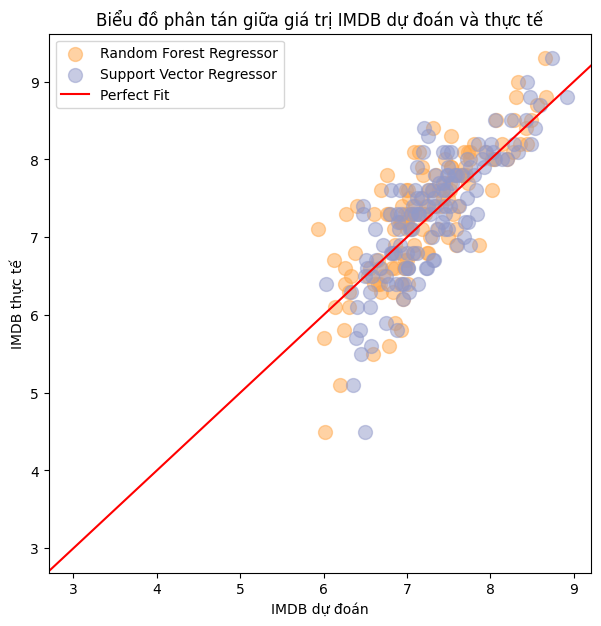

In [28]:
scatter(y_pred_rf, y_pred_svm, y_val)

In [31]:
#create dataframe with all results only mae score and show the improvement
results = pd.DataFrame({ 'Model': ['Random Forest', 'SVM', 'Random Forest', 'SVM', 'Random Forest', 'SVM'],
                        'Step': ['All Features', 'All Features', 'Selected Features', 'Selected Features', 'Tuned Hyperparams', 'Tuned Hyperparams'],
                        'MAE': [round(mae_rf,3), round(mae_svm,3), round(mae_rf_2,3), round(mae_svm_2,3), round(mae_rf_3,3), round(mae_svm_3,3)],
                        'RMSE': [round(rmse_rf,3), round(rmse_svm,3), round(rmse_rf_2,3), round(rmse_svm_2,3), round(rmse_rf_3,3), round(rmse_svm_3,3)],
                        'R2': [round(r2_rf,3), round(r2_svm,3), round(r2_rf_2,3), round(r2_svm_2,3), round(r2_rf_3,3), round(r2_svm_3,3)],
                        'MAE Improvement': ['-', '-', 
                                        round(mae_rf_2-mae_rf,3), 
                                        round(mae_svm_2-mae_svm,3), 
                                        round(mae_rf_3-mae_rf_2,3), 
                                        round(mae_svm_3-mae_svm_2,3)],
                        'RMSE Improvement': ['-', '-',
                                            round(rmse_rf_2-rmse_rf,3),
                                            round(rmse_svm_2-rmse_svm,3),
                                            round(rmse_rf_3-rmse_rf_2,3),
                                            round(rmse_svm_3-rmse_svm_2,3)],
                        'R2 Improvement': ['-', '-',
                                            round(r2_rf_2-r2_rf,3),
                                            round(r2_svm_2-r2_svm,3),
                                            round(r2_rf_3-r2_rf_2,3),
                                            round(r2_svm_3-r2_svm_2,3)]

                                        })
results

,Model,Step,MAE,RMSE,R2,MAE Improvement,RMSE Improvement,R2 Improvement
0,Random Forest,All Features,0.390,0.509,0.609,-,-,-
1,SVM,All Features,0.412,0.538,0.564,-,-,-
2,Random Forest,Selected Features,0.392,0.507,0.612,0.001,-0.002,0.003
3,SVM,Selected Features,0.420,0.548,0.548,0.007,0.009,-0.015
4,Random Forest,Tuned Hyperparams,0.379,0.493,0.633,-0.013,-0.014,0.021
5,SVM,Tuned Hyperparams,0.380,0.492,0.635,-0.04,-0.055,0.087


Từ bảng kết quả tổng hợp trên có thể đưa ra các nhận xét như sau:
- Bước mang lại cải thiện đáng kể nhất đối với cả 2 mô hình là lựa chọn tham số tối ưu (Tuned Hyperparams). Trong đó, độ cải thiện có thể nhận thấy rõ đối với SVM, chứng tỏ SVR phụ thuộc nhiều vào cấu hình tham số chính xác. Lựa chọn bộ tham số tối ưu không phù hợp có thể mang lại kết quả dự đoán tệ (MAE > 1.4), trong khi đó, với bộ tham số tối ưu phù hợp MAE có thể giảm xuống dưới 0.4.
- Mô hình RFR thì có thể đưa ra kết quả dự đoán tốt ngay với tham số mặc định, tuy nhiên nếu muốn mang lại cải thiện cho mô hình thì vẫn cần quá trình tối ưu các siêu tham số.

# Testing on test set

MAE - RMSE - R2 of Random Forest:  0.39 0.53 0.6
MAE - RMSE - R2 of SVM:  0.37 0.51 0.63


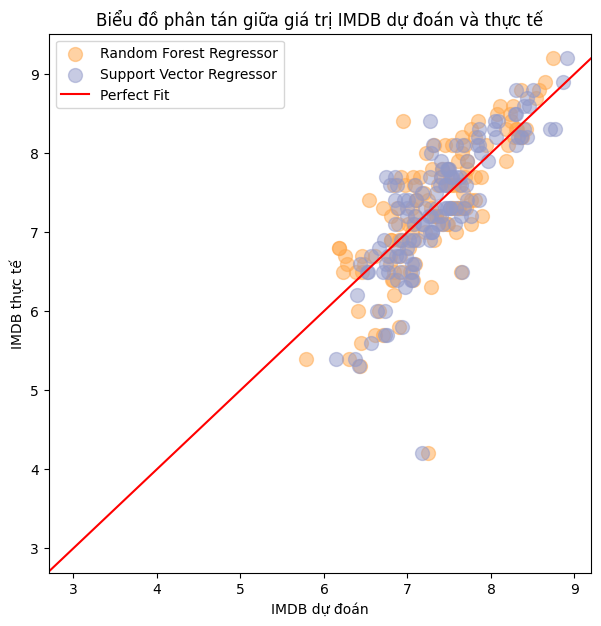

In [30]:
#test on hold set with final model
X_hold = pd.DataFrame(X_hold, columns=df.drop('imdb', axis=1).columns)

yhold_pred_rf = rf_model.predict(X_hold[best_features_svm])
yhold_pred_svm = svm_model.predict(X_hold[best_features_svm])

(mae_rf_4, rmse_rf_4, r2_rf_4) = calc_score(y_hold, yhold_pred_rf, 'Random Forest')
(mae_svm_4, rmse_svm_4, r2_svm_4) = calc_score(y_hold, yhold_pred_svm, 'SVM')

scatter(yhold_pred_rf, yhold_pred_svm, y_hold)

**Nhận xét:**
- Với tập dữ liệu hoàn toàn mới, cả hai mô hình đều cho ra kết quả dự đoán khá tốt và tương đồng nhau, điều này cho thấy mô hình không gặp các vấn đề như overfitting và underfitting.
- Mô hình khớp được ~60% dữ liệu và có khả năng dự đoán tốt IMDB rating của bộ phim (thông qua các giá trị MAE, RMSE, R2 được trình bày ở trên).

# Kết luận:
Bên cạnh những thành quả đạt được, một số vấn đề cần cải thiện:
- Sự đa dạng dữ liệu chưa đồng nhất, phân bố điểm IMDB rating của tập dữ liệu dùng để huấn luyện chưa đồng đều, có rất ít các bộ phim có điểm IMDB rating dưới 5 khiến mô hình cho kết quả dự đoán với sai số lớn.
- Sử dụng thuật toán lựa chọn đặc trưng chưa phù hợp, không góp phần cải thiện mô hình dự đoán.
